In [4]:
import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import folium

In [5]:
df = pd.read_csv('dataTaxi.csv')

In [6]:
df.head()

,Unnamed: 0,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,DoW,Hora_Inicio,Hora_Fin,distKilometros
0,1,-33.484436,-70.734913,-33.437822,-70.647421,1,sÃ¡bado,01-03-14 01:28,01-03-14 01:59,9.640889
1,3,-33.523092,-70.782872,-33.437234,-70.647150,0,sÃ¡bado,01-03-14 00:04,01-03-14 00:44,15.816194
2,4,-33.455709,-70.631109,-33.437341,-70.647136,0,sÃ¡bado,01-03-14 00:33,01-03-14 00:42,2.529204
3,5,-33.294220,-70.883511,-33.437682,-70.647190,0,sÃ¡bado,01-03-14 00:20,01-03-14 00:56,27.161926
4,6,-33.437601,-70.647152,-33.294479,-70.883178,10,sÃ¡bado,01-03-14 10:16,01-03-14 10:53,27.117458


# Problema 1

In [7]:
# Eliminamos la columna Unnamed:0 pq no entrega información relevante (parece haber sido un indice)
df = df.drop(columns=["Unnamed: 0"])

Nos dimos cuenta que existen algunas filas que empiezan el viaje después de terminarlo, lo que no es posible y tiene que ser un error de tipeo, por la que las eliminaremos:

In [8]:
# Verificar cuantas filas tienen hora_inicio posterior a hora_fin
df['Hora_Inicio_Antes'] = df['Hora_Inicio'] < df['Hora_Fin']
df['Hora_Inicio_Antes'].value_counts()

print("Porcentaje de columnas con Hora_Inicio > Hora_Fin: ", round(df['Hora_Inicio_Antes'].value_counts()[False]/len(df),4)*100)
# Como no es un valor alto, los eliminaremos del df
df = df[df['Hora_Inicio_Antes'] != False]
len(df)
df = df.drop(columns='Hora_Inicio_Antes') # Era solo una columna auxiliar

Porcentaje de columnas con Hora_Inicio > Hora_Fin:  1.87


Luego, creamos una nueva variable llamada 'Duracion', para saber cuantos minutos dura cada viaje; la variable 'Mes' y la variable 'Año'.
Así tenemos la información en un formato más cómodo

In [9]:
# Crear variable Duracion que indica la duracion del viaje
df["Hora_Inicio"] = pd.to_datetime(df["Hora_Inicio"], format='%d-%m-%y %H:%M')
df["Hora_Fin"] = pd.to_datetime(df["Hora_Fin"], format='%d-%m-%y %H:%M')
df["Duracion"] = (df["Hora_Fin"] - df["Hora_Inicio"]).dt.total_seconds() / 60
# Extraer la informacion del mes en que se realizo el viaje
df["Mes"] = df["Hora_Inicio"].dt.month
df["Año"] = df["Hora_Inicio"].dt.year
# Ahora que tenemos Horas, Tiempo_de_trayectoria, Mes y Año, extrajimos toda la info de las variables Hora_Inicio y Hora_Fin por lo que podemos eliminarlas para trabajar con ese formato
df = df.drop(columns=["Hora_Inicio", "Hora_Fin"])
df.head()

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,DoW,distKilometros,Duracion,Mes,Año
0,-33.484436,-70.734913,-33.437822,-70.647421,1,sÃ¡bado,9.640889,31.0,3,2014
1,-33.523092,-70.782872,-33.437234,-70.647150,0,sÃ¡bado,15.816194,40.0,3,2014
2,-33.455709,-70.631109,-33.437341,-70.647136,0,sÃ¡bado,2.529204,9.0,3,2014
3,-33.294220,-70.883511,-33.437682,-70.647190,0,sÃ¡bado,27.161926,36.0,3,2014
4,-33.437601,-70.647152,-33.294479,-70.883178,10,sÃ¡bado,27.117458,37.0,3,2014


Se puede ver que hay viajes que duran muchas horas, hasta más de un día, probablemente por errores de tipeo en la base de datos. Por esto, vamos a eliminar las filas que tengan una duración inusual.

In [10]:
# Verificar si hay viajes de tiempos inusuales que puedan ser erroneos

# Definir la duración máxima en minutos para considerar "inusual"
duracion_maxima_minutos = (60*4)  # 4 horas

# Filtrar las filas que tienen duración inusual
viajes_inusuales = df[df["Duracion"] > duracion_maxima_minutos]

viajes_inusuales

# Eliminar las filas inusuales del DataFrame original
df = df.drop(viajes_inusuales.index)

No podemos trabajar con variables categóricas -> días de la semana
Vamos a dividir el dataframe en 2: uno con los viajes realizados en días laborales (lunes-viernes) y otro con fin de semana (sabado-domingo)
Esto porque consideramos que la información útil para analizar el comportamiento de los taxis puede estar en si es dia laboral (y las personas viajan al trabajo), o si es fin de semana y tienen otro comportamiento.

Entonces, no nos importa el día específico de la semana en que se realizó el viaje, ya tenemos la info. que queremos, y no vamos a considerar la variable 'DoW'

También hay que considerar que la variable 'Mes', a pesar de ser numérica en el df, es realmente categórica. Como no están todos los meses considerados (solo ([ 3,  2,  7,  6,  5, 11, 10])) = (Feb, Mar, May, Jun, Jul, Oct, Nov), decidimos eliminar la variable ya que no creemos que contenga información muy relevante para determinar el comportamiento de los viajes en taxi.

In [11]:
print(df['Mes'].unique())
df = df.drop(columns='Mes')
df['DoW'].unique()

[ 3  2  7  6  5 11 10]


array(['sÃ¡bado', 'domingo', 'lunes', 'martes', 'miÃ©rcoles', 'jueves',
       'viernes'], dtype=object)

¿ Dejamos Año?

In [12]:
# Creamos dos dataframe por separado, con toda la info. de los viajes para dias laborales y no laborales

# Filtrar los días de la semana (lunes a viernes)
df_semana = df.loc[df['DoW'].isin(['lunes', 'martes', 'miÃ©rcoles', 'jueves', 'viernes'])]
df_semana = df_semana.drop(columns=['DoW'])
# Filtrar los días de fin de semana (sábado y domingo)
df_finde = df.loc[df['DoW'].isin(['sÃ¡bado', 'domingo'])]
df_finde = df_finde.drop(columns=['DoW'])

df_semana.head()

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,distKilometros,Duracion,Año
153,-33.503851,-70.570742,-33.437884,-70.646972,9,10.199649,26.0,2014
154,-33.397645,-70.792605,-33.440057,-70.604312,6,18.121038,28.0,2014
155,-33.479281,-70.737451,-33.393417,-70.614121,8,14.920535,29.0,2014
156,-33.397335,-70.794151,-33.478825,-70.757923,16,9.675450,23.0,2014
157,-33.442092,-70.652221,-33.480578,-70.561577,3,9.445583,22.0,2014


Hay que estandarizar los dataframe, están en escalas distintas y como K-Means es algoritmo de distancia va a darle más importancia a las variables con escalas mayores

In [13]:
from sklearn.preprocessing import StandardScaler

columnas_estandarizar = ['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Horas', 'distKilometros', 'Duracion', 'Año']

scaler = StandardScaler()

# No quiero perder los originales
df_semana_est = df_semana.copy()
df_finde_est = df_finde.copy()

df_semana_est[columnas_estandarizar] = scaler.fit_transform(df_semana_est[columnas_estandarizar])
df_finde_est[columnas_estandarizar] = scaler.fit_transform(df_finde_est[columnas_estandarizar])

Visualizar los dataframes que utilizaremos:

In [14]:
df_semana_est.head()

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,distKilometros,Duracion,Año
153,-1.253949,1.128590,0.050334,0.167014,-0.465403,-0.051151,-0.301526,-1.454972
154,0.696474,-1.862298,0.013528,0.722597,-0.907662,1.035063,-0.232652,-1.454972
155,-0.802740,-1.118775,0.803523,0.594850,-0.612822,0.596197,-0.198215,-1.454972
156,0.702158,-1.883131,-0.643131,-1.277975,0.566536,-0.123031,-0.404837,-1.454972
157,-0.119773,0.030184,-0.672832,1.279162,-1.349922,-0.154551,-0.439274,-1.454972


In [12]:
df_finde_est.head()

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,distKilometros,Duracion,Año
0,-0.716540,-0.882700,0.234956,0.246176,-1.118912,-0.391836,0.088626,-1.404718
1,-1.377560,-1.485373,0.243553,0.249462,-1.257676,0.455629,0.548419,-1.404718
2,-0.225313,0.421727,0.241981,0.249635,-1.257676,-1.367805,-1.035313,-1.404718
3,2.536164,-2.750021,0.237001,0.248977,-1.257676,2.012656,0.344067,-1.404718
4,0.084343,0.220124,2.331885,-2.608380,0.129961,2.006553,0.395155,-1.404718


# Pregunta 2

# Prueba 1: separar laboral-finde y aplicar kmeans con LatitudPAB	LongitudPAB	LatitudCOM	LongitudCOM

# Días de semana (laborales)

Comenzamos viendo cual es el número óptimo de clusters (k) según Whitin Cluster Distance

[1541523.999999993, 1249523.46212484, 1018988.7829403782, 834984.0990318498, 705815.3769077177, 651410.2544002226, 601199.37829638, 555034.4149694245, 517352.49571032805, 492639.95277421945, 466998.34779764875, 451329.3887714102, 427737.0329484381, 410028.655643663, 394387.84733923385, 383725.91302245914, 370591.1149515093, 355403.67079339613, 346622.9450006884, 332825.85424176475, 321498.71419329586, 314475.08807076147, 305971.96420745476, 295573.0716926423]


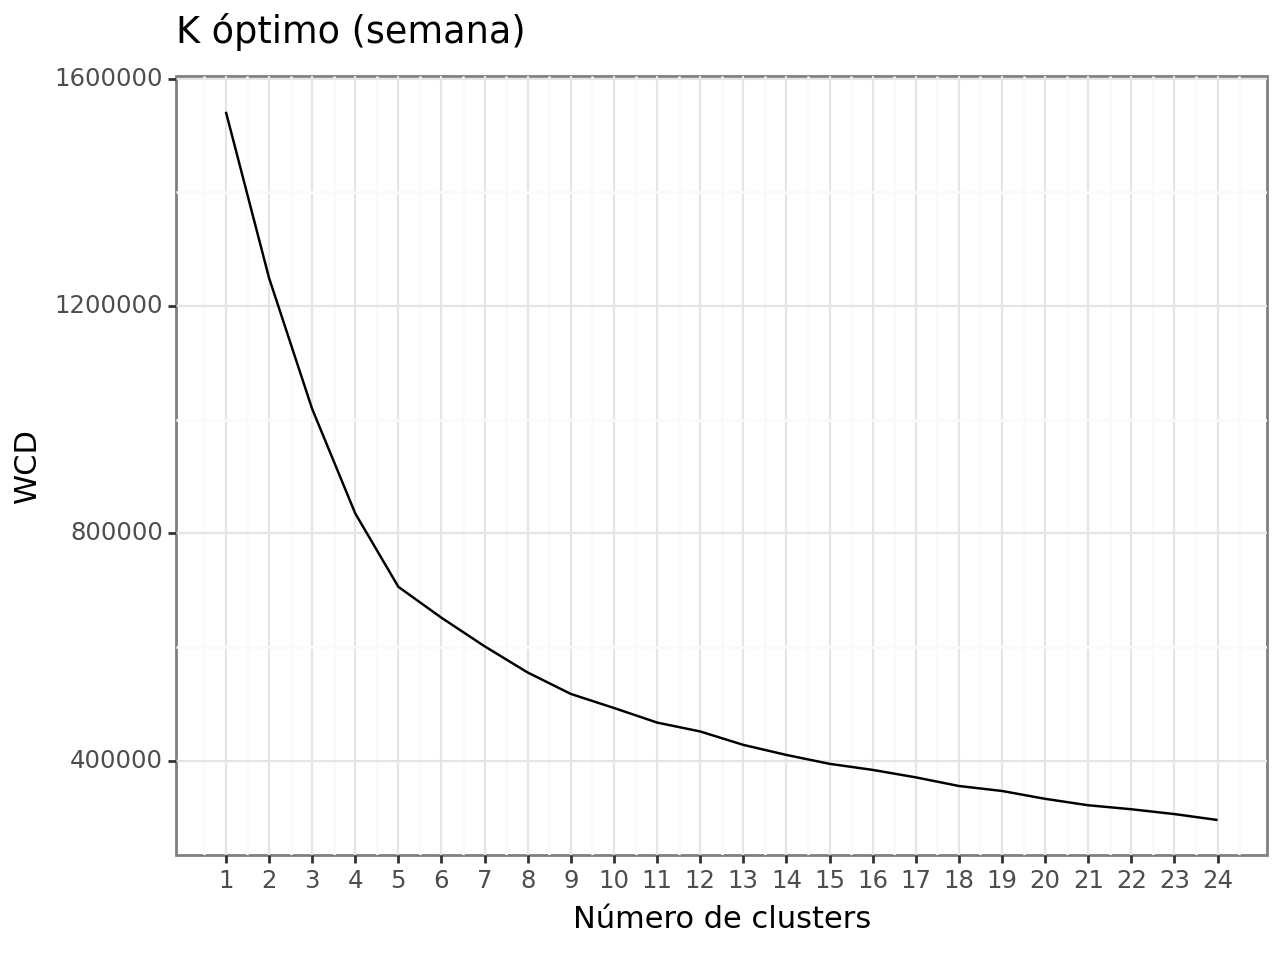

<Figure Size: (640 x 480)>

In [13]:
sse = []
numK = 25
features = df_semana_est[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM']]
for k in range(1, numK):
    kmeans = KMeans(n_clusters=k,n_init=5)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)
print(sse)

tempDataFrame = pd.DataFrame(range(1, numK), columns=["numK"])
tempDataFrame["sse"] = sse

(ggplot(tempDataFrame)+aes(x="numK", y="sse")+theme_bw()+geom_line()+labs(x = "Número de clusters", y = "WCD")
 +scale_x_continuous(breaks=range(1,numK))+ggtitle("K óptimo (semana)"))

Elijo 8 cluster (se empieza a suavizar la curva)

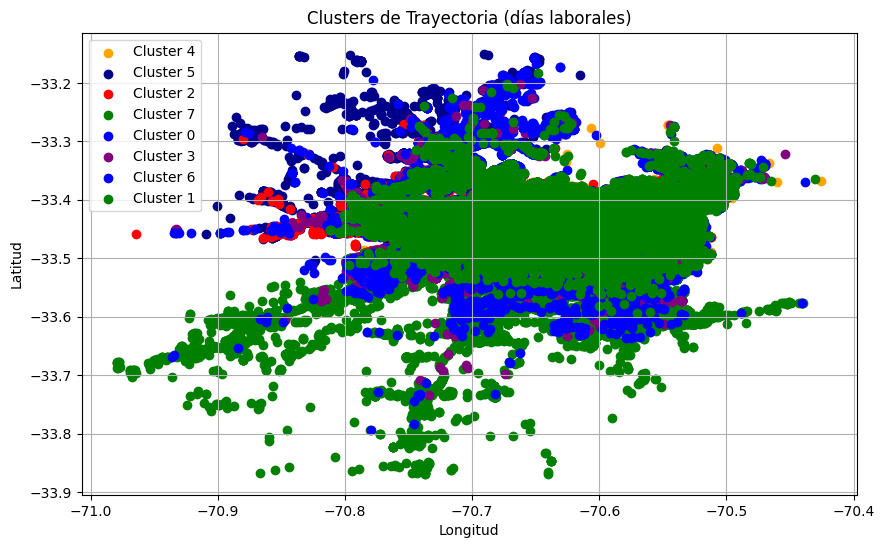

In [15]:
from sklearn.cluster import KMeans

features = df_semana_est[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM']]

# Aplicar K-Means a los datos estandarizados (df_semana_est)
kmeans = KMeans(n_clusters=8, random_state=0, n_init=5)
clusters_semana = kmeans.fit_predict(df_semana_est[columnas_estandarizar])

# Agregar las etiquetas de clusters a df_semana
df_semana_est['Cluster'] = clusters_semana
df_semana['Cluster'] = clusters_semana # Para seguir teniendo la informacion sin estandarizar + los clusters creados

# Para los clusters:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue'] #, 'darkgreen', 'darkred', 'cadetblue', 'lightgreen', 'beige', 'pink', 'cyan', 'magenta', 'yellow'

import matplotlib.pyplot as plt

# Visualizar los resultados en el espacio de latitud y longitud originales (sin estandarizar)
plt.figure(figsize=(10, 6))

for cluster in df_semana_est['Cluster'].unique():
    cluster_data = df_semana[df_semana_est['Cluster'] == cluster]
    plt.scatter(cluster_data['LongitudPAB'], cluster_data['LatitudPAB'], color=colors[cluster % len(colors)], label=f'Cluster {cluster}')

plt.title('Clusters de Trayectoria (días laborales)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import folium
from geopy.distance import great_circle
import numpy as np

# Función para calcular la dirección de la flecha
def calculate_arrow_direction(start_coord, end_coord):
    start_lat, start_lon = start_coord
    end_lat, end_lon = end_coord
    angle = np.arctan2(end_lat - start_lat, end_lon - start_lon)
    return angle

# Crea un mapa centrado en las coordenadas iniciales
mapa = folium.Map(location=[df_semana['LatitudPAB'].mean(), df_semana['LongitudPAB'].mean()], zoom_start=12)

# Definir colores únicos para cada cluster
colors = ['blue', 'green', 'red', 'purple', 'black', 'darkblue', 'darkgreen', 'darkred']

# Agrega marcadores y flechas para los puntos de inicio y fin de trayectoria por cluster
for i, cluster in enumerate(df_semana_est['Cluster'].unique()):
    cluster_data = df_semana[df_semana_est['Cluster'] == cluster]
    start_centroid = cluster_data[['LatitudPAB', 'LongitudPAB']].mean()
    end_centroid = cluster_data[['LatitudCOM', 'LongitudCOM']].mean()
    
    # Calcula la dirección de la flecha
    arrow_direction = calculate_arrow_direction([start_centroid['LatitudPAB'], start_centroid['LongitudPAB']],
                                                [end_centroid['LatitudCOM'], end_centroid['LongitudCOM']])
    
    # Agrega marcadores en forma de estrella para los puntos de inicio y fin con colores únicos
    folium.Marker(location=[start_centroid['LatitudPAB'], start_centroid['LongitudPAB']],
                  icon=folium.Icon(color=colors[i], icon='star'),
                  popup=f'Inicio Cluster {cluster}').add_to(mapa)
    
    folium.Marker(location=[end_centroid['LatitudCOM'], end_centroid['LongitudCOM']],
                  icon=folium.Icon(color=colors[i], icon='none'),
                  popup=f'Fin Cluster {cluster}').add_to(mapa)
    
    # Calcula la distancia entre los puntos de inicio y fin
    distance = great_circle([start_centroid['LatitudPAB'], start_centroid['LongitudPAB']],
                            [end_centroid['LatitudCOM'], end_centroid['LongitudCOM']]).meters
    
    # Crea una PolyLine con una flecha para representar la trayectoria con el color del cluster
    folium.PolyLine(locations=[(start_centroid['LatitudPAB'], start_centroid['LongitudPAB']),
                               (end_centroid['LatitudCOM'], end_centroid['LongitudCOM'])],
                    color=colors[i],
                    weight=2,
                    opacity=0.7,
                    popup=f'Distancia: {distance:.2f} metros').add_to(mapa)

# Agrega etiquetas de colores en una esquina del mapa
for i, cluster in enumerate(df_semana_est['Cluster'].unique()):
    mapa.get_root().html.add_child(folium.Element(f'<div style="background-color: {colors[i]}; color: white; padding: 5px;">Cluster {cluster}</div>'))

# Muestra el mapa interactivo
mapa


# Fin de semana

Ver k óptimo para fin de semana:

[218736.00000000017, 173852.52460348874, 138271.2587389495, 117078.27699693503, 97630.5271102465, 88445.8897424954, 81855.27384003579, 75506.88455227003, 70849.16163025926, 67646.06862484998, 64613.81107231077, 61566.39985945647, 59286.43417916772, 56715.120245617916, 54574.857863356585, 52035.643870007305, 50178.20709901218, 48309.0627782658, 47215.02748315866, 45052.991561152376, 43609.433988368866, 42870.448517442805, 42173.060518515646, 40366.42273532746]


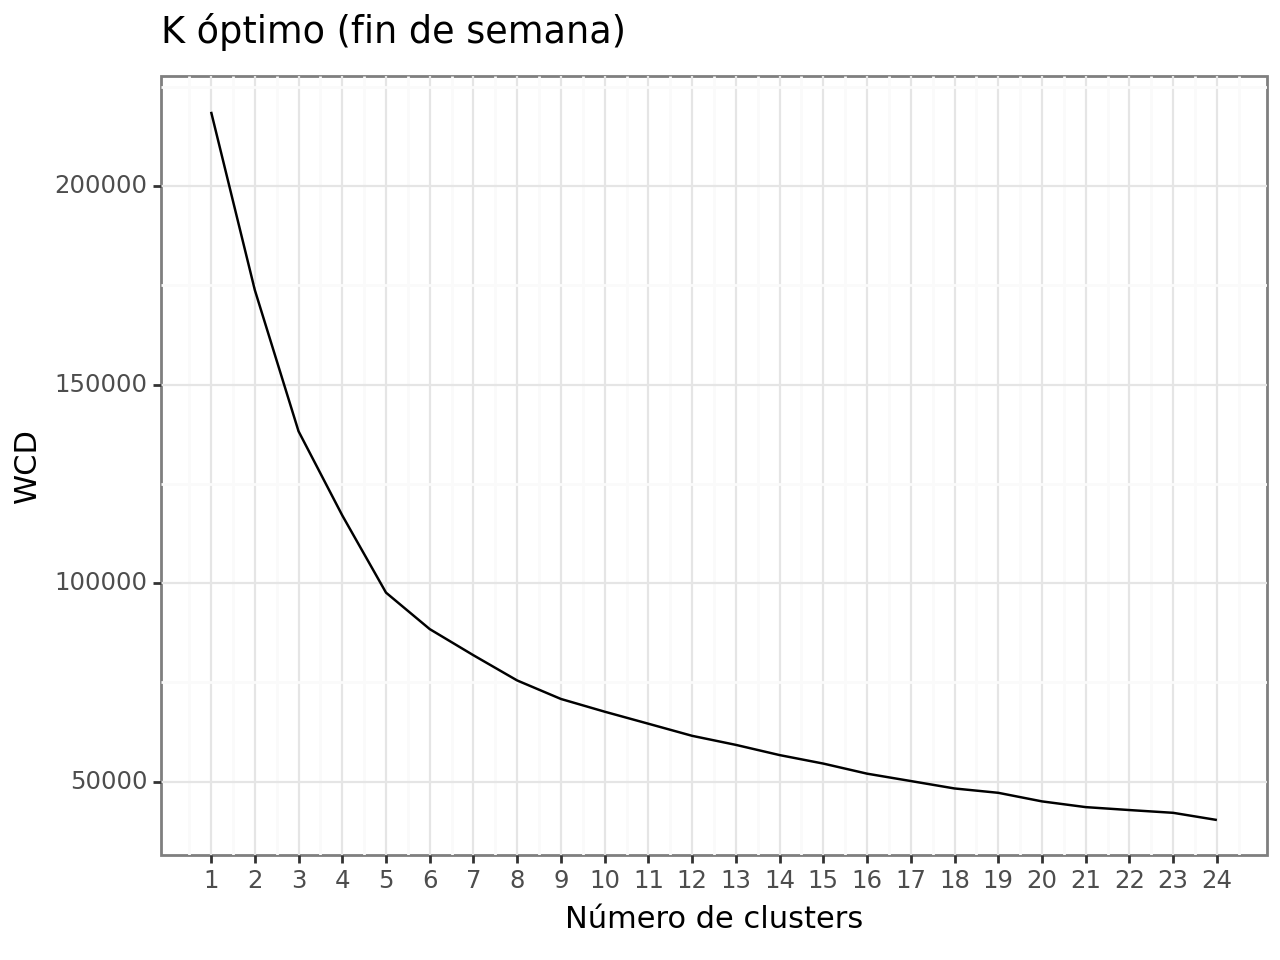

<Figure Size: (640 x 480)>

In [35]:
sse_ = []
numK = 25
features_ = df_finde_est[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM']]
for k in range(1, numK):
    kmeans_ = KMeans(n_clusters=k,n_init=5)
    kmeans_.fit(features_)
    sse_.append(kmeans_.inertia_)
print(sse_)

tempDataFrame_ = pd.DataFrame(range(1, numK), columns=["numK"])
tempDataFrame_["sse"] = sse_

(ggplot(tempDataFrame_)+aes(x="numK", y="sse")+theme_bw()+geom_line()+labs(x = "Número de clusters", y = "WCD")
 +scale_x_continuous(breaks=range(1,numK))+ggtitle("K óptimo (fin de semana)"))

Usaré k=9

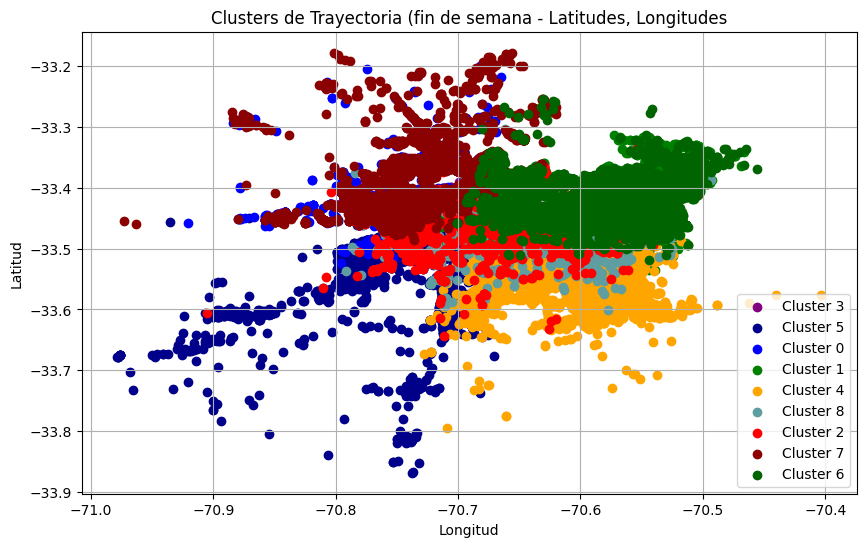

In [17]:
from sklearn.cluster import KMeans

features_1 = df_finde_est[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM']]

# Aplicar K-Means a los datos estandarizados (df_semana_est)
kmeans_1 = KMeans(n_clusters=9, random_state=0, n_init=5)
clusters_finde_1 = kmeans_1.fit_predict(features_1)

# Agregar las etiquetas de clusters a df_semana
df_finde_est['Cluster'] = clusters_finde_1
df_finde['Cluster'] = clusters_finde_1

# Para los clusters:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'darkgreen', 'darkred', 'cadetblue']
# 'lightgreen', 'beige', 'pink', 'cyan', 'magenta', 'yellow']

import matplotlib.pyplot as plt

# Visualizar los resultados en el espacio de latitud y longitud originales (sin estandarizar)
plt.figure(figsize=(10, 6))

for cluster_1 in df_finde_est['Cluster'].unique():
    cluster_data_1 = df_finde[df_finde_est['Cluster'] == cluster_1]
    plt.scatter(cluster_data_1['LongitudPAB'], cluster_data_1['LatitudPAB'], color=colors[cluster_1 % len(colors)], label=f'Cluster {cluster_1}')

plt.title('Clusters de Trayectoria (fin de semana - Latitudes, Longitudes')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import folium
from geopy.distance import great_circle
import numpy as np

# Crea un mapa centrado en las coordenadas iniciales
mapa_finde = folium.Map(location=[df_finde['LatitudPAB'].mean(), df_finde['LongitudPAB'].mean()], zoom_start=12)

# Definir colores únicos para cada cluster
colors_finde = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'darkgreen', 'darkred', 'cadetblue']

# Agrega marcadores y flechas para los puntos de inicio y fin de trayectoria por cluster
for i, cluster in enumerate(df_finde_est['Cluster'].unique()):
    cluster_data_finde = df_finde[df_finde_est['Cluster'] == cluster]
    start_centroid_finde = cluster_data_finde[['LatitudPAB', 'LongitudPAB']].mean()
    end_centroid_finde = cluster_data_finde[['LatitudCOM', 'LongitudCOM']].mean()
    
    # Calcula la dirección de la flecha
    arrow_direction_finde = calculate_arrow_direction([start_centroid_finde['LatitudPAB'], start_centroid_finde['LongitudPAB']],
                                                [end_centroid_finde['LatitudCOM'], end_centroid_finde['LongitudCOM']])
    
    # Agrega marcadores en forma de estrella para los puntos de inicio y fin con colores únicos
    folium.Marker(location=[start_centroid_finde['LatitudPAB'], start_centroid_finde['LongitudPAB']],
                  icon=folium.Icon(color=colors_finde[i], icon='star'),
                  popup=f'Inicio Cluster {cluster}').add_to(mapa_finde)
    
    folium.Marker(location=[end_centroid_finde['LatitudCOM'], end_centroid_finde['LongitudCOM']],
                  icon=folium.Icon(color=colors_finde[i], icon='none'),
                  popup=f'Fin Cluster {cluster}').add_to(mapa_finde)
    
    # Calcula la distancia entre los puntos de inicio y fin
    distance_finde = great_circle([start_centroid_finde['LatitudPAB'], start_centroid_finde['LongitudPAB']],
                            [end_centroid_finde['LatitudCOM'], end_centroid_finde['LongitudCOM']]).meters
    
    # Crea una PolyLine con una flecha para representar la trayectoria con el color del cluster
    folium.PolyLine(locations=[(start_centroid_finde['LatitudPAB'], start_centroid_finde['LongitudPAB']),
                               (end_centroid_finde['LatitudCOM'], end_centroid_finde['LongitudCOM'])],
                    color=colors_finde[i],
                    weight=2,
                    opacity=0.7,
                    popup=f'Distancia: {distance:.2f} metros').add_to(mapa_finde)

# Agrega etiquetas de colores en una esquina del mapa
for i, cluster in enumerate(df_finde_est['Cluster'].unique()):
    mapa_finde.get_root().html.add_child(folium.Element(f'<div style="background-color: {colors_finde[i]}; color: white; padding: 5px;">Cluster {cluster}</div>'))

# Muestra el mapa interactivo
mapa_finde

# Pregunta 3 (Interpretar el modelo)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analisis_clusters(df, kmeans, var_to_analyze, df_name, cluster_colors):
    cluster_stats = pd.DataFrame(np.zeros((kmeans.n_clusters, 2)), columns=["mean", "std"])

    # Calcular el promedio y la desviación estándar de la variable para cada cluster
    for i in range(kmeans.n_clusters):
        cluster_data = df[df['Cluster'] == i]
        cluster_stats.loc[i, 'mean'] = cluster_data[var_to_analyze].mean()
        cluster_stats.loc[i, 'std'] = cluster_data[var_to_analyze].std()

    plt.figure(figsize=(10, 6))

    for i, row in cluster_stats.iterrows():
        color = cluster_colors[i]  # Obtener el color del cluster desde la lista de colores
        plt.vlines(i, ymin=row['mean'] - row['std'], ymax=row['mean'] + row['std'], color=color, alpha=0.7, linewidth=2)
        plt.scatter(i, row['mean'], color=color, marker='o', s=100)
        plt.hlines(y=row['mean'] - row['std'], xmin=i - 0.1, xmax=i + 0.1, color=color, linestyle='-', linewidth=2)
        plt.hlines(y=row['mean'] + row['std'], xmin=i - 0.1, xmax=i + 0.1, color=color, linestyle='-', linewidth=2)

    plt.xticks(range(kmeans.n_clusters))
    plt.xlabel('Clusters')
    plt.ylabel(var_to_analyze)
    plt.title(f'Análisis de {var_to_analyze} por Cluster - Datos: {df_name}')
    plt.grid(True)
    plt.show()

# Ejemplo de uso
cluster_colors = ['black', 'darkred', 'red', 'darkblue', 'blue', 'green', 'darkgreen', 'purple']

In [41]:
df_semana

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,distKilometros,Duracion,Año,Cluster
153,-33.503851,-70.570742,-33.437884,-70.646972,9,10.199649,26.0,2014,7
154,-33.397645,-70.792605,-33.440057,-70.604312,6,18.121038,28.0,2014,1
155,-33.479281,-70.737451,-33.393417,-70.614121,8,14.920535,29.0,2014,7
156,-33.397335,-70.794151,-33.478825,-70.757923,16,9.675450,23.0,2014,1
157,-33.442092,-70.652221,-33.480578,-70.561577,3,9.445583,22.0,2014,7
...,...,...,...,...,...,...,...,...,...
451196,-33.468094,-70.761627,-33.444859,-70.665214,23,9.320362,43.0,2016,1
451201,-33.457553,-70.700590,-33.549217,-70.612245,22,13.090884,151.0,2016,5
451204,-33.457468,-70.700292,-33.553663,-70.768412,22,12.435832,100.0,2016,5
451208,-33.457722,-70.700615,-33.377248,-70.625947,22,11.330739,72.0,2016,3


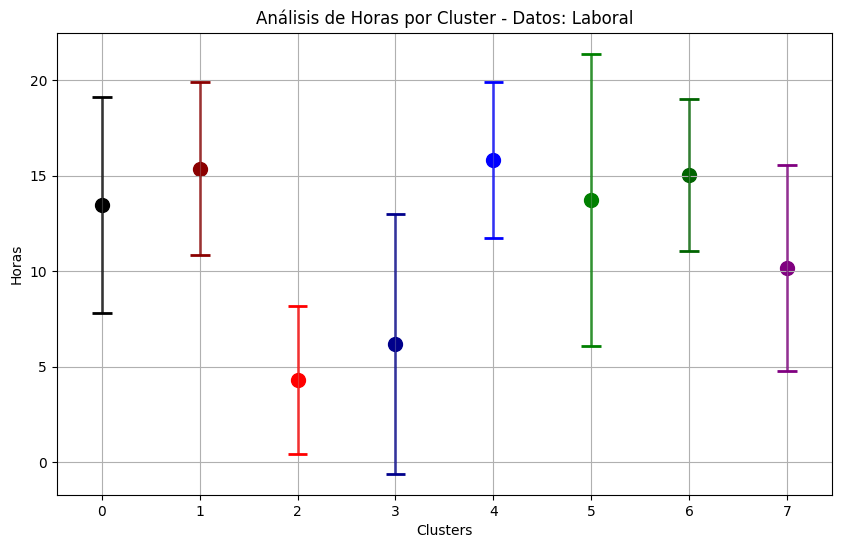

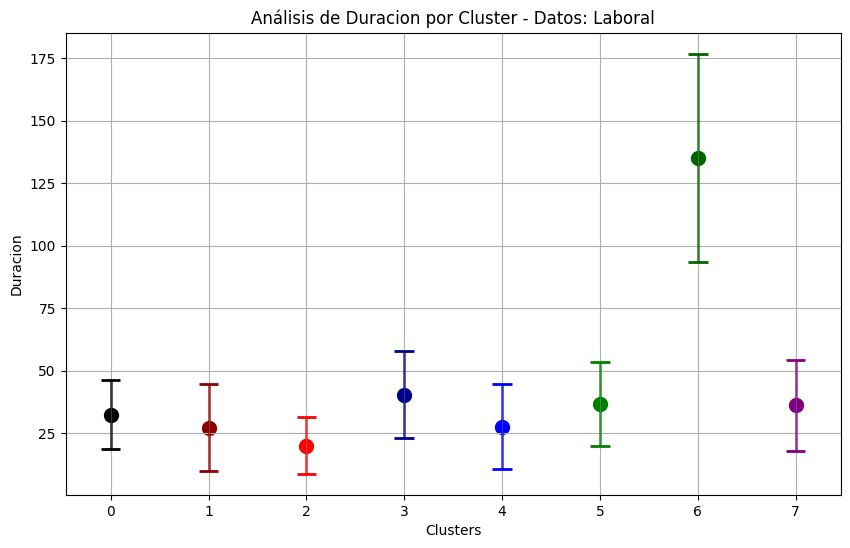

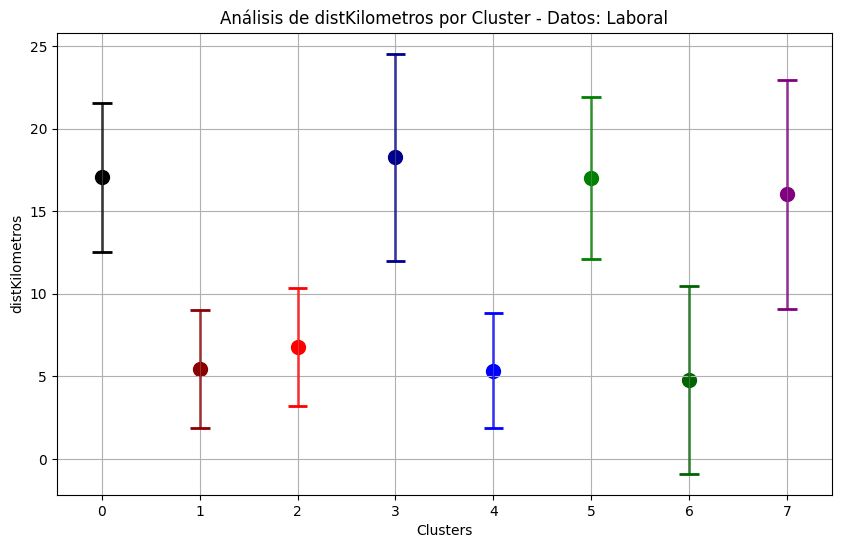

In [21]:
analisis_clusters(df_semana, kmeans, 'Horas', 'Laboral', cluster_colors)
analisis_clusters(df_semana, kmeans, 'Duracion', 'Laboral', cluster_colors)
analisis_clusters(df_semana, kmeans, 'distKilometros', 'Laboral', cluster_colors)

Finde

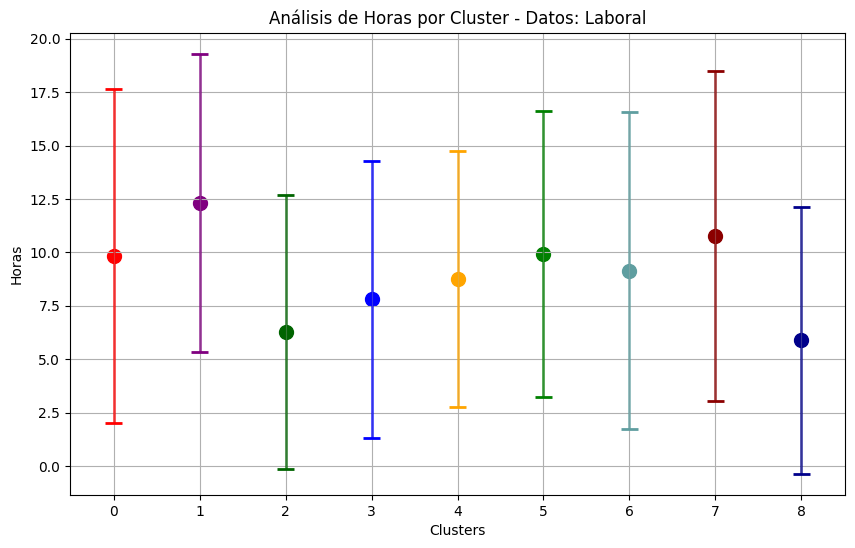

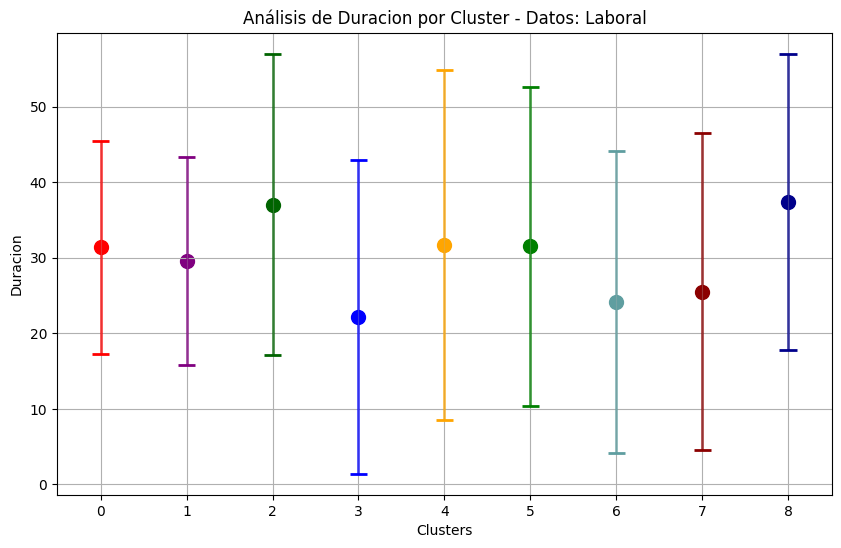

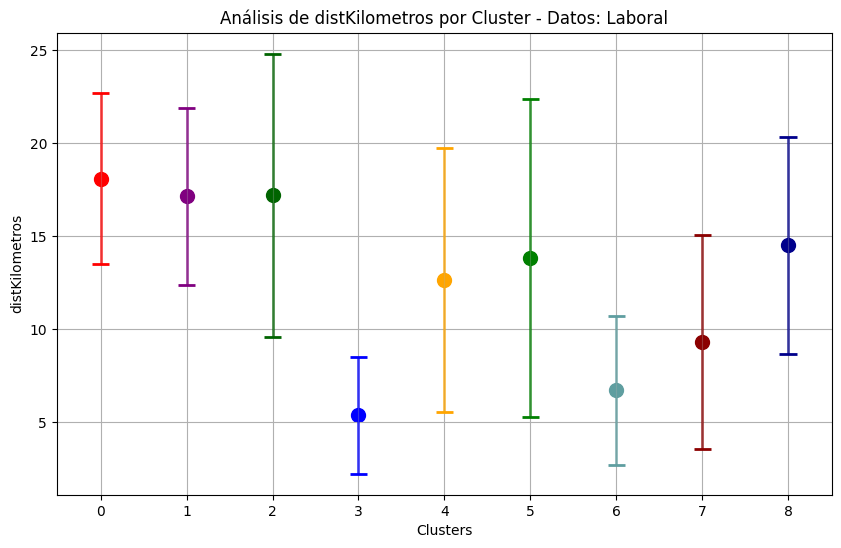

In [26]:
colors_finde = ['red', 'purple', 'darkgreen', 'blue', 'orange', 'green', 'cadetblue', 'darkred', 'darkblue']

analisis_clusters(df_finde, kmeans_1, 'Horas', 'Laboral', colors_finde)
analisis_clusters(df_finde, kmeans_1, 'Duracion', 'Laboral', colors_finde)
analisis_clusters(df_finde, kmeans_1, 'distKilometros', 'Laboral', colors_finde)